## Filtrado basado en contenido con una red neuronal

En el laboratorio de filtrado colaborativo, generaste dos vectores: un vector de usuario y un vector de ítem/película, cuyo producto punto predeciría una calificación. Estos vectores se derivaron únicamente de las calificaciones.

El filtrado basado en contenido también genera un vector de características de usuario y de película, pero reconoce que puede haber otra información disponible sobre el usuario y/o la película que pueda mejorar la predicción. Esta información adicional se proporciona a una red neuronal que luego genera los vectores de usuario y película como se muestra a continuación.

<figure>
    <center> <img src="./img/RecSysNN.png"   style="width:500px;height:280px;" ></center>
</figure>

La información de la película proporcionada a la red es una combinación de los datos originales y algunas "características diseñadas". Las características originales son el año de lanzamiento de la película y el género de la película presentado como un vector one-hot. Hay 14 géneros. La característica diseñada es una calificación promedio derivada de las calificaciones de los usuarios. Las películas con múltiples géneros tienen un vector de entrenamiento por género.

El contenido del usuario está compuesto únicamente por características diseñadas. Se calcula un promedio de calificaciones por género para cada usuario. Además, hay disponible un ID de usuario, un recuento de calificaciones y un promedio de calificaciones, pero no se incluyen en el contenido de entrenamiento o predicción. Son útiles para interpretar los datos.

El conjunto de entrenamiento consiste en todas las calificaciones realizadas por los usuarios en el conjunto de datos. Los vectores de usuario y película/ítem se presentan a la red anterior juntos como un conjunto de entrenamiento. El vector de usuario es el mismo para todas las películas calificadas por el usuario.


In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

#from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
#minmaxscaler
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import IterableDataset, DataLoader, get_worker_info

import pyarrow.dataset as ds

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# class RecommenderDataset(Dataset):
#     def __init__(self, user_features, item_features, targets,
#                  user_scaler=None, item_scaler=None, target_scaler=None):
#         """
#         Dataset para sistema de recomendación content-based.
#         Recibe datos YA escalados, y opcionalmente guarda los escalers usados.
#         """
#         self.user_features = torch.tensor(user_features, dtype=torch.float32)
#         self.item_features = torch.tensor(item_features, dtype=torch.float32)
#         self.targets       = torch.tensor(targets      , dtype=torch.float32)
# 
#         self.user_scaler   = user_scaler
#         self.item_scaler   = item_scaler
#         self.target_scaler = target_scaler
# 
#     def __len__(self):
#         return len(self.targets)
# 
#     def __getitem__(self, idx):
#         return self.user_features[idx], self.item_features[idx], self.targets[idx]
# 
#     @classmethod
#     def from_split(cls, user_features, item_features, targets,
#                    test_size=0.2, random_state=31415):
#         """
#         Divide los datos en train/test, ajusta los scalers solo con train,
#         transforma ambos y devuelve los datasets listos.
#         """
# 
#         X_user_train, X_user_test, X_item_train, X_item_test, y_train, y_test = train_test_split(
#             user_features, item_features, targets, test_size=test_size, random_state=random_state, stratify=targets
#         )
# 
# 
#         user_scaler   = StandardScaler()
#         item_scaler   = StandardScaler()
#         target_scaler = MinMaxScaler(feature_range=(-1, 1))
# 
#         X_user_train = user_scaler.fit_transform(X_user_train)
#         X_item_train = item_scaler.fit_transform(X_item_train)
#         y_train      = target_scaler.fit_transform(y_train)
# 
#         X_user_test = user_scaler.transform(X_user_test)
#         X_item_test = item_scaler.transform(X_item_test)
#         y_test      = target_scaler.transform(y_test)
# 
#         train_ds = cls(X_user_train, X_item_train, y_train,
#                        user_scaler, item_scaler, target_scaler)
#         test_ds  = cls(X_user_test, X_item_test, y_test,
#                        user_scaler, item_scaler, target_scaler)
# 
#         return train_ds, test_ds
# 


class InteractionDataset(IterableDataset):
    def __init__(self, interactions_path, user_feat, item_feat, u_map, i_map, batch_size=4096, max_rows=None):
        self.user_feat  = user_feat
        self.item_feat  = item_feat
        self.u_map      = u_map
        self.i_map      = i_map

        # batch_size = tamaño de lectura (NO de entrenamiento)
        self.batch_size = batch_size
        self.max_rows   = max_rows

        # Leer SOLO columnas necesarias
        self.dataset = ds.dataset(
            interactions_path,
            format="parquet"
        )
    def __len__(self):
        if self.max_rows is not None:
            return min(self.max_rows, self.dataset.count_rows())
        return self.dataset.count_rows()

    def __iter__(self):
        #worker  = get_worker_info()
        counter = 0
        for idx, batch in enumerate(self.dataset.to_batches(batch_size=self.batch_size)):
            #if idx % worker.num_workers != worker.id:
            #    continue
            yield from self._process_batch(batch)
            counter+=1
            if self.max_rows is not None and counter >= self.max_rows:
                return


    def _process_batch(self, batch):
        table = batch.to_pydict()

        user_ids = np.asarray(table["userID"] , dtype=np.int32)
        item_ids = np.asarray(table["animeID"], dtype=np.int32)
        #labels   = np.asarray(table["label"]  , dtype=np.float32)
        ratings  = np.asarray(table["rating"] , dtype=np.float32)

        u_idx = np.fromiter((self.u_map.get(u, -1) for u in user_ids), dtype=np.int32, count=len(user_ids))
        i_idx = np.fromiter((self.i_map.get(i, -1) for i in item_ids), dtype=np.int32, count=len(item_ids))

        mask = (u_idx >= 0) & (i_idx >= 0)
        if not mask.any():
            return


        yield {
            # IDs (solo para evaluación / logging)
            "user_id": torch.from_numpy(user_ids[mask]),
            "item_id": torch.from_numpy(item_ids[mask]),

            # Features (input real del modelo)
            "user_batch": torch.from_numpy(self.user_feat[u_idx[mask]]),
            "item_batch": torch.from_numpy(self.item_feat[i_idx[mask]]),

            # Targets
            "rating": torch.from_numpy(ratings[mask]),
        }




In [4]:
data_root = "../../data/data_anime/prod/"

#Users
user_df = pd.read_parquet(data_root+"user_final")
user_df = user_df.set_index("userID").sort_index()

#Items
item_df = pd.read_parquet(data_root+"item_final")
item_df = item_df.set_index("animeID").sort_index()


In [5]:
#train test split

#train = pd.read_parquet(data_root + "train_interactions")

#from sklearn.model_selection import train_test_split

#train, test = train_test_split(train, test_size=0.2, random_state=42)


In [6]:

class encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim=32, hidden_dim=[256, 128], p=0.5):
        super(encoder, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dim + [embedding_dim]
        for i in range(len(dims) - 2):
            layers.extend(
                [
                    nn.Linear(dims[i], dims[i + 1]),
                    nn.ReLU(),
                    nn.Dropout(p=p),
                ]
            )
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

        for layer in self.net:
            if isinstance(layer, nn.Linear): nn.init.normal_(layer.weight, std=0.01)
        

        #self.net = nn.Sequential(
        # nn.Linear(input_dim, 256), nn.ReLU(), nn.Dropout(p=0.5),
        # nn.Linear(256, 128)      , nn.ReLU(), nn.Dropout(p=0.5),
        # nn.Linear(128, embedding_dim)
        #)

    def forward(self, x):
        #return nn.functional.normalize(self.net(x), dim=1, eps=1e-8)
        return self.net(x)

class UserBasesFiltering(nn.Module):
    def __init__(
        self, 
        num_user_features, 
        num_item_features, 
        embedding_dim=32, 
        hidden_dim=[256, 128],
        p=0.5):

        super(UserBasesFiltering, self).__init__()
        self.user_tower = encoder(num_user_features, embedding_dim, hidden_dim, p)
        self.item_tower = encoder(num_item_features, embedding_dim, hidden_dim, p)

    def forward(self, user_features, item_features):
        u_emb = self.user_tower(user_features)    # (batch, embedding_dim)
        i_emb = self.item_tower(item_features)    # (batch, embedding_dim)

        #score = (u_emb * i_emb).sum(dim=1, keepdim=True)   #Ahora se usa aprendizaje costrastivo

        #return score  # (batch, 1)
        return u_emb, i_emb


Lo siguiente tiene un problema, si bien la informacion de "year", "episodes" y "score" son features muy interezantes para un sistema de recomendación, no son features que se puedan usar directamente en el modelo. 

Estos features pueden hacer que el modelo sature rapidamente, haciendo que el modelo no aprenda a predecir la similitud entre los items.

Los features son discretos y el rango que tienen es

* year: {1907,...,2026}
* episodes: {0,...,3057}
* score: {1,...,10}

Estos son rangos del set de entrenamiento, por lo que pude varian un poco en el set de testeo, aun así uno quiere tratar de scalar estos valores.
Se quiere lograr la tipica normalización de datos.
Los rangos propuestos son los siguienes.

* year: {1907,...,2026} -> {1900,...,2030}
* episodes: {0,...,3057} -> {0,...,4000} Seguro One piece jeje, pero hay de 10mil masomenos, son muy pocos, no los considero
* score: {1,...,10} -> {0,...,10}

y con esto puedo escalar por min_max scaler. y llevarlos a un rango de {0,1}

$x_{scaled} = (x - x_{min})/ (x_{max}-x_{min})$


In [7]:
item_df.describe()
#claramente la cantidad de episodios no es gaussiana, no puedo usar StandardScaler.
# Si podria con score, ahi muy justo.

,score,episodes,year,0,1,2,3,4,5,6,...,310,311,312,313,314,315,316,317,318,319
count,19598.000000,19598.000000,19598.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,...,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.00000,19483.000000,19483.000000,19483.000000
mean,6.312016,12.832177,2008.612256,0.268080,0.011395,0.015603,0.010419,0.008982,0.011343,0.010163,...,0.013037,0.011035,0.011138,0.015347,0.015501,0.010111,0.00811,0.012421,0.015193,0.006980
std,1.008972,61.998038,14.765114,0.442971,0.106138,0.123938,0.101545,0.094350,0.105902,0.100299,...,0.113436,0.104470,0.104950,0.122931,0.123536,0.100048,0.08969,0.110758,0.122322,0.083259
min,1.730000,0.000000,1907.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,5.610000,1.000000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,6.340000,2.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,7.040000,12.000000,2019.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,10.000000,3057.000000,2026.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [8]:

class MinMaxScaler(nn.Module):
    def __init__(self, min_val, max_val, log=False, eps=1e-8):
        super().__init__()
        self.log = log
        self.eps = eps

        self.register_buffer("min", torch.tensor(min_val, dtype=torch.float32))
        self.register_buffer("max", torch.tensor(max_val, dtype=torch.float32))

    def forward(self, x):
        if self.log:
            x = torch.log1p(x)
            minv = torch.log1p(self.min)
            maxv = torch.log1p(self.max)
        else:
            minv, maxv = self.min, self.max

        x = (x - minv) / (maxv - minv + self.eps)
        return torch.clamp(x, 0.0, 1.0)

class ItemFeaturePipeline(nn.Module):
    def __init__(self):
        super().__init__()

        self.year     = MinMaxScaler(1_900, 2_030)
        self.episodes = MinMaxScaler(0, 4_000, log=True)
        self.score    = MinMaxScaler(0, 10)

    def forward(self, x):

        x[:, 0] = self.year(x[:, 0])
        x[:, 1] = self.episodes(x[:, 1])
        x[:, 2] = self.score(x[:, 2])

        #return torch.tensor(x, dtype=torch.float32)
        # If you need to detach from the computation graph
        return x.clone().detach().to(dtype=torch.float32)

class UserFeaturePipeline(nn.Module):
    def forward(self, x):
        return torch.clamp(x / 10.0, 0.0, 1.0)



# --- USERS ---
user_pipeline = UserFeaturePipeline().to(device)
user_tensor   = torch.tensor(user_df.values, dtype=torch.float32, device=device)
user_features = user_pipeline(user_tensor).cpu().numpy()

user_id_to_row = {uid: i for i, uid in enumerate(user_df.index)}

# --- ITEMS ---
item_pipeline = ItemFeaturePipeline().to(device)
item_tensor   = torch.tensor( item_df.fillna(0).values, dtype=torch.float32, device=device)
item_features = item_pipeline(item_tensor).cpu().numpy()

item_id_to_row = {iid: i for i, iid in enumerate(item_df.index)}


Osea que solo me va a poder recomendar peliculas desde 1900 hasta 2030, habra que darle mantenimiento en el 2030 a este jeje!


In [9]:

dataset_train = InteractionDataset(
    data_root+"train_interactions",
    user_features,
    item_features,
    user_id_to_row,
    item_id_to_row,
    batch_size = 64,
    max_rows= None #100_000#64*100
)
train_loader = DataLoader(
    dataset_train,
    batch_size=None,          # OBLIGATORIO con IterableDataset batchificado
    pin_memory=True,
)


dataset_test = InteractionDataset(
    data_root+"test_data",
    user_features,
    item_features,
    user_id_to_row,
    item_id_to_row,
    batch_size = 64,
    max_rows= None#20_000
)
test_loader = DataLoader(
    dataset_test,
    batch_size=None,
    pin_memory=True,
)


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Collect all ratings
all_ratings = []
for batch in train_loader:
    all_ratings.extend(batch["rating"].numpy())

# Convert to numpy array for easier manipulation
all_ratings = np.array(all_ratings)




/home/brian/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Rating statistics:
Min rating: 1.0
Max rating: 10.0
Mean rating: 8.03
Median rating: 8.00
Unique ratings: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


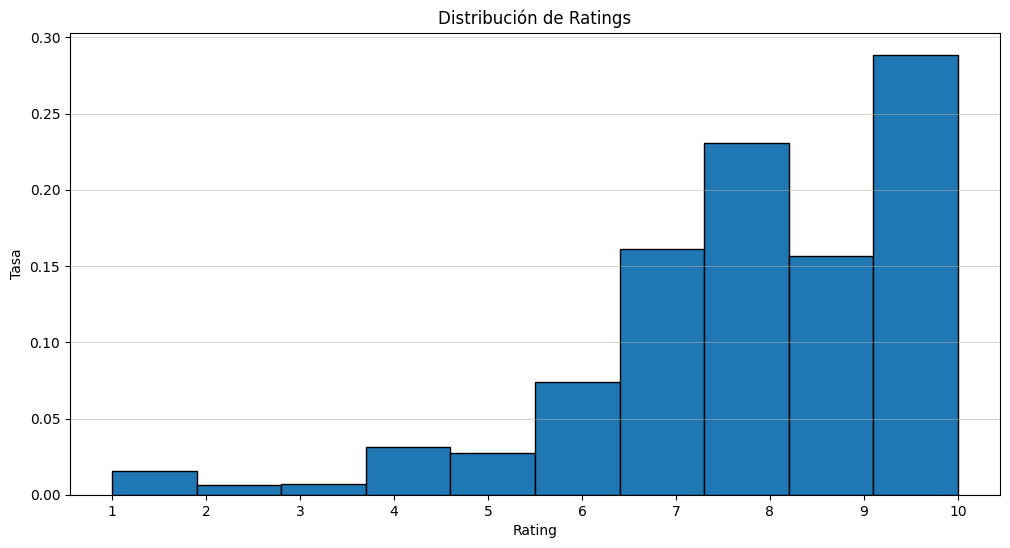


Rating distribution:
Rating 1.0: 489715 samples (1.59%)
Rating 2.0: 191065 samples (0.62%)
Rating 3.0: 223451 samples (0.72%)
Rating 4.0: 963612 samples (3.12%)
Rating 5.0: 851150 samples (2.76%)
Rating 6.0: 2291516 samples (7.42%)
Rating 7.0: 4983303 samples (16.13%)
Rating 8.0: 7134345 samples (23.10%)
Rating 9.0: 4844236 samples (15.68%)
Rating 10.0: 8916924 samples (28.87%)


In [11]:
# Print basic statistics
print("Rating statistics:")
print(f"Min rating: {all_ratings.min()}")
print(f"Max rating: {all_ratings.max()}")
print(f"Mean rating: {all_ratings.mean():.2f}")
print(f"Median rating: {np.median(all_ratings):.2f}")
print(f"Unique ratings: {np.unique(all_ratings)}")

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(all_ratings,
 bins=len(np.unique(all_ratings)),
 weights=np.ones_like(all_ratings)/len(all_ratings),
 edgecolor='black', )
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Tasa')
plt.xticks(np.unique(all_ratings))
plt.grid(axis='y', alpha=0.5)
plt.show()

# Check class distribution
unique, counts = np.unique(all_ratings, return_counts=True)
print("\nRating distribution:")
for rating, count in zip(unique, counts):
    print(f"Rating {rating}: {count} samples ({count/len(all_ratings)*100:.2f}%)")

In [12]:
n_users = {}
# Count users with ratings >= 0.7
for batch in train_loader:
    high_rating_mask  = batch['rating'] >= 7
    high_rating_users = batch['user_id'][high_rating_mask]
    for user_id in high_rating_users:
        user_id = int(user_id)
        n_users[user_id] = n_users.get(user_id, 0) + 1

# Calculate average
average_high_ratings = sum(n_users.values()) / len(n_users) if n_users else 0
print(f"Average number of high ratings per user: {average_high_ratings}")

Average number of high ratings per user: 27.714476340406847


In [13]:
def get_model(path_model):
    """
    Obtiene ultimo modelo entrenado.
    """
    import os
    file_list = os.listdir(path_model)
    if len(file_list) == 0: return None

    index_list = [0]*len(file_list)
    for i, file in enumerate(file_list):
        index_list[i] = int(file.split(".")[0].split("checkpoint")[1])
        
    max_idx= max(index_list)
    return file_list[index_list.index(max_idx)]


In [14]:
print(f"feature_item_dimension: {item_df.shape[1]}")
print(f"feature_user_dimension: {user_df.shape[1]}")

#La primer columna corresponmde a los respectivos Ids
num_user_features = user_df.shape[1]
num_item_features = item_df.shape[1]
dim_embedding = 256 #128

path_model = "../../models/TwoTowerEmb/"

model = UserBasesFiltering(
    num_user_features,
    num_item_features,
    dim_embedding,
    [256, 512],
    0.5
).to(device)
#cargar siempre el ultimo.pth, es de tipo checkpoint000x.pth
if True:
    actual_model = get_model(path_model)
    if actual_model is not None: 
        print(f"actual_model: {actual_model}")
        checkpoint = torch.load(path_model + actual_model, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])


feature_item_dimension: 323
feature_user_dimension: 320
actual_model: checkpoint0009.pth


## Entrenamiento del modelo

$$
\mathcal{L}(\hat{y}, y) = \mathbb{E}[w(y) (\hat{y} - y)^2]
$$

In [15]:
class SimilarityMSELoss:
    def __init__(self, scaler=False):
        self.cos = nn.CosineSimilarity(dim=1)
        self.loss = nn.MSELoss()
        self.scaler = scaler
    
    def __call__(self, user_ebatch, item_ebatch, ratings_batch):
        score_pred = self.cos(user_ebatch, item_ebatch)
        if self.scaler:
            ratings_batch = ratings_batch/10
        return self.loss(score_pred, ratings_batch)

class WeightedMSELoss(torch.nn.Module):
    def __init__(self, rating_weights, rating_scale = (0, 10), scale=(-1, 1)):
        super().__init__()
        self.rating_weights = rating_weights
        self.mse = nn.MSELoss(reduction="none")
        self.rating_scale = rating_scale
        self.scale = scale

    def forward(self, user_ebatch, item_ebatch, ratings_batch):
        # pred: (batch,)
        # target: (batch,) ratings reales

        rating_pred = (user_ebatch * item_ebatch).sum(dim=1)

        w = torch.tensor(
            [self.rating_weights[int(r.item())] for r in ratings_batch],
            device=rating_pred.device,
            dtype =rating_pred.dtype
        )

        if self.scale:
            #Min max scaler en el intervalo -1 1
            ratings_batch = ratings_batch - self.rating_scale[0]
            ratings_batch = ratings_batch / (self.rating_scale[1] - self.rating_scale[0])
            ratings_batch = ratings_batch * (self.scale[1] - self.scale[0]) + self.scale[0]


        return torch.mean(w * self.mse(rating_pred, ratings_batch))


class DotProductMSELoss(nn.Module):
    def __init__(self, scaler=True):
        super().__init__()
        self.loss = nn.MSELoss()
        self.scale_ratings = scaler

    def forward(self, user_ebatch, item_ebatch, ratings_batch):
        score_pred = (user_ebatch * item_ebatch).sum(dim=1)

        if self.scale_ratings:
            ratings_batch = ratings_batch / 10.0  # o el max real

        return self.loss(score_pred, ratings_batch)


class Loss(torch.nn.Module):
    def __init__(self, path_weights: str, rating_scale = (0, 10), scale=(-1, 1), margin=0.3, wloss = [1., 1.]):
        super().__init__()
        self.mse            = nn.MSELoss(reduction="none")
        self.rating_scale   = rating_scale
        self.scale          = scale
        self.margin         = margin
        self.lambda1, self.lambda2 = wloss
        self.w_freq         = self._get_wfreq(path_weights)

    def forward(self, user_ebatch, item_ebatch, ratings_batch):
        # pred:   (batch,)
        # target: (batch,) ratings reales
        #
        rating_pred = (user_ebatch * item_ebatch).sum(dim=1)

        if self.scale: #Min max scaler en el intervalo -1 1
            ratings_batch = self._scale(ratings_batch)

        l1 = self._pairwiseLoss(rating_pred, ratings_batch, self.margin)
        l2 = self._weightedLoss(rating_pred, ratings_batch)
    
        return self.lambda1 * l1 + self.lambda2 * l2

    def _scale(self, ratings_batch):
        ratings_batch = ratings_batch - self.rating_scale[0]
        ratings_batch = ratings_batch / (self.rating_scale[1] - self.rating_scale[0])
        ratings_batch = ratings_batch * (self.scale[1] - self.scale[0]) + self.scale[0]
        return ratings_batch

    def _pairwiseLoss(self, pred, target, margin=0.5):
        """ Diferencia entre pares consecutivos tal que |pred - target|> margin """

        #Estos son matrices de diferencias entre todos los pares posibles de ratings.
        diff_target = target.unsqueeze(1) - target.unsqueeze(0)
        diff_pred   = pred.unsqueeze(1)   - pred.unsqueeze(0)

        mask = diff_target > margin   # solo pares con diferencia real
        loss = F.relu(margin - diff_pred[mask])
        return loss.mean() if mask.any() else 0.0
    
    def _weightedLoss(self, pred, target):
        """  L = sum(w * (pred - target)^2) """
        w = torch.tensor(
            [self.w_freq[int(r.item())] for r in target],
            device=pred.device,
            dtype =pred.dtype
        )
        return torch.mean(w * self.mse(pred, target))

    def _get_wfreq(self, path):
        weights = {}

        df = pd.read_csv(
            path, 
            header=None,
            names=["rating", "count", "normalized_freq"]) 

        for r, p in zip(df["rating"], df["normalized_freq"]):
            weights[int(r)] = 1.0 / np.sqrt(p)

        # normalizar (MUY importante)
        mean_w = np.mean(list(weights.values()))
        weights = {r: w / mean_w for r, w in weights.items()}   #AUX SACO NORMALIZACION DE PESOS!
        
        w_scaled = {}
        if self.scale: # sdignifica que ahora las claves van a estar en otro rango
            for k, v in weights.items():
                w_scaled[self._scale(k)] = v 

        return w_scaled






In [16]:
#rating_freq_test.csv/part-00000-a68a81fd-85b8-4332-86e4-7fdb54b6031c-c000.csv
#insertar columnas user_id, item_id, rating
pd.read_csv(
    data_root + "rating_freq_test.csv/part-00000-a68a81fd-85b8-4332-86e4-7fdb54b6031c-c000.csv", 
    header=None, 
    names=["user_id", "item_id", "rating"]
)
   

,user_id,item_id,rating
0,0,5510,0.000720
1,1,122358,0.015978
2,2,47213,0.006165
3,3,54740,0.007148
4,4,240599,0.031418
5,5,209884,0.027407
6,6,567503,0.074107
7,7,1236148,0.161421
8,8,1767299,0.230781
9,9,1196170,0.156201


In [17]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.CosineEmbeddingLoss()
#criterion = SimilarityMSELoss(scaler=True)
#criterion = DotProductMSELoss(scaler=False)
#criterion = RatingMarginLoss(margin=0.7)
#criterion = nn.MSELopath_modelss()


import torch
import pandas as pd
import numpy as np

#torch.save(weights, path + "rating_weights.pt")

#criterion = WeightedMSELoss(weights)
path_weights = data_root + "rating_freq_test.csv/part-00000-a68a81fd-85b8-4332-86e4-7fdb54b6031c-c000.csv"
criterion = Loss(path_weights, margin=0.5)


if False:
    num_epochs = 32#256

    epoch_init = 0
    if actual_model is not None: epoch_init = checkpoint["epoch"]

    for epoch in range(epoch_init, num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:

            # "user_id": 
            # "item_id": 
            # "user_batch": 
            # "item_batch": 
            # "label":  
            # "rating": 

            optimizer.zero_grad()
            #outputs = model(user_batch, item_batch)
            user_embedding, item_embedding = model(batch["user_batch"].to(device), batch["item_batch"].to(device))

            #loss    = criterion(user_embedding, item_embedding, target_batch.squeeze())
            loss    = criterion(user_embedding, item_embedding, batch["rating"].to(device))
            #print(f"epoch: {epoch} | Loss: {loss.item()}")
            assert not torch.isnan(loss), f"Loss is NaN \n user_batch: {batch['user_batch']} \n user_min: {batch['user_batch'].min()} \n item_batch: {batch['item_batch']} \n item_min: {batch['item_batch'].min()} \n target_batch: {batch['label']} \n ratings_batch: {batch['rating']}"
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
   
        avg_loss = running_loss / len(train_loader) #running_loss / batch_size
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

        #guardar el modelo.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f"{path_model}checkpoint{epoch:04d}.pth")


In [18]:
#Plot loss in epoch 

In [19]:
#with torch.no_grad():
#    cos_scores = (user_embedding* item_embedding).sum(dim=1)
#    print(cos_scores.mean(), cos_scores.std())
#    
#print(torch.quantile(cos_scores, torch.tensor([0.1, 0.5, 0.9])))
#
#
#
#count = 0
#print(f"quantile [0.1, 0.5, 0.9]")
#for batch in train_loader:
#    count += 1
#    if count > 20: break
#    u_emb, i_emb = model(batch["user_batch"], batch["item_batch"])
#
#    cos_scores = (u_emb * i_emb).sum(dim=1)
#
#    print(f"quantile ref, {torch.quantile(batch['rating'], torch.tensor([0.1, 0.5, 0.9]))}:   obtenido: {torch.quantile(cos_scores, torch.tensor([0.1, 0.5, 0.9]))}")
#    
#

## Evaluación del modelo

In [20]:
#Cargo el modelo
if True:
    checkpoint = torch.load(path_model+actual_model)
    model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
with torch.no_grad():
    total_loss = 0.0
    for batch in test_loader:
        user_batch, item_batch = batch["user_batch"].to(device), batch["item_batch"].to(device)

        user_embedding, item_embedding = model(user_batch, item_batch)
        # si y=-1 -> criterion = max(0,cos(x1,x2))

        loss = criterion(user_embedding, item_embedding, batch["rating"].to(device))
        total_loss += loss.item()

    print(f"Test Loss: {total_loss / len(test_loader):.4f}")


/tmp/ipykernel_46168/2807039317.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_model+actual_model)


Test Loss: 0.0077


Rating statistics:
Min rating: 0.0
Max rating: 10.0
Mean rating: 8.00
Median rating: 8.00
Unique ratings: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


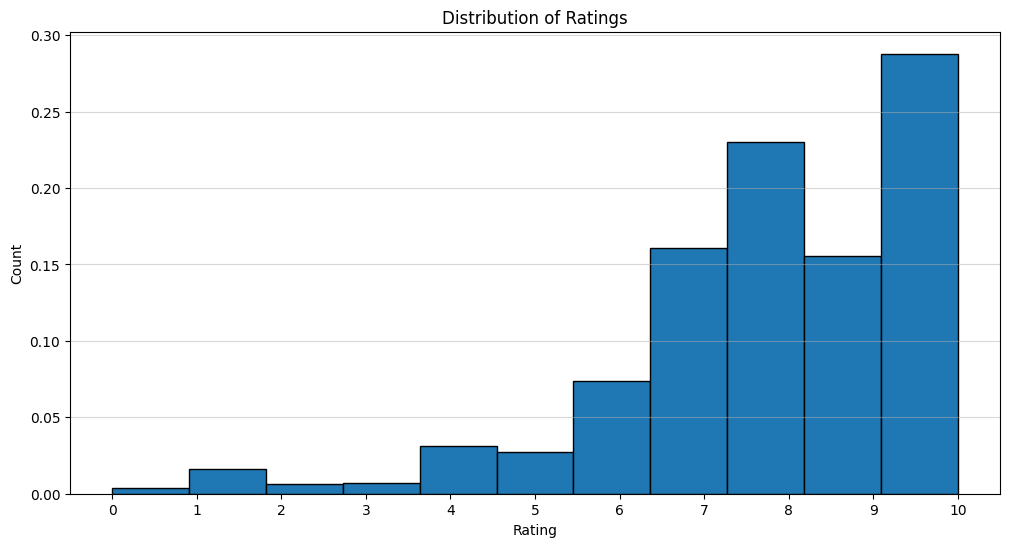


Rating distribution:
Rating 0.0: 28002 samples (0.36%)
Rating 1.0: 122357 samples (1.59%)
Rating 2.0: 47210 samples (0.61%)
Rating 3.0: 54735 samples (0.71%)
Rating 4.0: 240592 samples (3.13%)
Rating 5.0: 209880 samples (2.73%)
Rating 6.0: 567488 samples (7.39%)
Rating 7.0: 1236119 samples (16.10%)
Rating 8.0: 1767253 samples (23.01%)
Rating 9.0: 1196147 samples (15.57%)
Rating 10.0: 2210347 samples (28.78%)


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Collect all ratings
all_ratings = []
for batch in test_loader:
    all_ratings.extend(batch["rating"].numpy())

# Convert to numpy array for easier manipulation
all_ratings = np.array(all_ratings)

# Print basic statistics
print("Rating statistics:")
print(f"Min rating: {all_ratings.min()}")
print(f"Max rating: {all_ratings.max()}")
print(f"Mean rating: {all_ratings.mean():.2f}")
print(f"Median rating: {np.median(all_ratings):.2f}")
print(f"Unique ratings: {np.unique(all_ratings)}")

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(all_ratings,
 bins=len(np.unique(all_ratings)),
 weights=np.ones_like(all_ratings)/len(all_ratings),
 edgecolor='black', )
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(np.unique(all_ratings))
plt.grid(axis='y', alpha=0.5)
plt.show()

# Check class distribution
unique, counts = np.unique(all_ratings, return_counts=True)
print("\nRating distribution:")
for rating, count in zip(unique, counts):
    print(f"Rating {rating}: {count} samples ({count/len(all_ratings)*100:.2f}%)")

In [22]:
class InteractionScorer:
    """
    Ejecuta inferencia del modelo y produce scores escalares.
    """

    def __init__(self, model, device, score_range=(0, 1)):
        self.model = model
        self.device = device
        self.s_min, self.s_max = score_range

    def score_batch(self, user_batch, item_batch):
        """
        Returns
        -------
        scores : torch.Tensor shape [B]
        """
        user_batch = user_batch.to(self.device)
        item_batch = item_batch.to(self.device)

        user_emb, item_emb = self.model(user_batch, item_batch)

        # IMPLEMENTACIÓN REEMPLAZABLE
        #scores = F.cosine_similarity(user_emb, item_emb, dim=1)
        scores = (user_emb * item_emb).sum(dim=1).clamp(min=self.s_min, max=self.s_max)

        return scores


# aggregation.py
from collections import defaultdict

class UserInteractionStore:
    """
    Almacena scores y labels agrupados por usuario.
    """

    def __init__(self):
        self.pred    = defaultdict(list)
        self.target  = defaultdict(list)
        self.item_id = defaultdict(list)

    def add_batch(self, user_ids, pred, target, items):
        for u, s, y, i in zip(user_ids, pred, target, items):
            uid = int(u)
            self.pred[uid].append(float(s))
            self.target[uid].append(int(y))
            self.item_id[uid].append(int(i))

    def users(self):
        return self.pred.keys()

    def get_user_data(self, user_id):
        return np.array(self.pred[user_id]), np.array(self.target[user_id]), np.array(self.item_id[user_id])


# topk.py
import numpy as np

def topk_indices(scores, k):
    """
    Retorna índices de los top-k scores.
    Complejidad: O(n)
    """
    scores = np.asarray(scores)

    if len(scores) <= k:
        return np.argsort(scores)[::-1]

    idx = np.argpartition(scores, -k)[-k:]
    return idx[np.argsort(scores[idx])[::-1]]

In [23]:
import sys
import os

# Agrega el directorio padre al path de Python
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import (
    precision_at_k,
    recall_at_k,
    hit_rate_at_k,
    apk,
    ndcg_at_k,
    mae,
    mse,
    rmse
)




# evaluator.py
class Evaluator:
    def __init__(self, scorer, k=10, relevant_threshold=0.7):
        self.scorer = scorer
        self.k = k
        self.relevant_threshold = relevant_threshold

    def evaluate(self, dataloader):
        store = UserInteractionStore()

        self.scorer.model.eval() # este es nuestro modelo entrenado
        with torch.no_grad():
            for batch in dataloader:
                pred_scores = self.scorer.score_batch(batch["user_batch"].to(device), batch["item_batch"].to(device))
                #Internamente guarda por cada usuario.
                store.add_batch(
                    user_ids= batch["user_id"].cpu(),
                    pred    = pred_scores.cpu()/10, #(0,1)
                    target  = batch["rating"].cpu(),#(0,10)
                    items   = batch["item_id"].cpu(),
                )

        return self._compute_metrics(store)

    def _compute_metrics(self, store):
        ndcgs      = self._compute_metric_at_k(store, ndcg_at_k)
        precisions = self._compute_metric_at_k(store, precision_at_k)
        recalls    = self._compute_metric_at_k(store, recall_at_k)
        hits       = self._compute_metric_at_k(store, hit_rate_at_k)

        return {
            f"NDCG@{self.k}":       float(np.mean(ndcgs)),
            f"Precision@{self.k}":  float(np.mean(precisions)),
            f"Recall@{self.k}":     float(np.mean(recalls)),
            f"HitRate@{self.k}":    float(np.mean(hits)),
        }

    def _sort_items(self, items, scores):
        """
        Recibe dos listas ina de items otra de scores, organiza los items segun los scores siendo el primero elemento el de mayor score.
        """
        sort_idx = np.argsort(scores)[::-1]
        return items[sort_idx], scores[sort_idx]
        

    def _compute_metric_at_k(self, store, metric_at_k):
        """ Computa la metrica por cada usuari"""
        metric = []
        for u in store.users():
            #prediccion de score, score real, items del usuario
            preds, targets, items = store.get_user_data(u)  #notar que no importa el rango de los ratings sino un orden de relevantes.
            #Obtengo los items mas relevantes.
            #print(f"targets: {targets}")
            #print(f"preds: {preds}")
            item_relevants = items[targets >= self.relevant_threshold]
            #Ordeno los items segun los scores, para obtener los topk items recomendados
            items, preds = self._sort_items(items, preds)

            # metric(items_recomendados, _items_relevantes) al primero tomo los topk, asume que hay almenos k items
            metric.append(metric_at_k(items, list(item_relevants), self.k))

        return metric

    


scorer    = InteractionScorer(model, device)
evaluator = Evaluator(scorer, k=10, relevant_threshold=0.4)
evaluator.evaluate(test_loader)

{'NDCG@10': 0.9987451492043701,
 'Precision@10': 0.6394497770836008,
 'Recall@10': 0.8891970610870356,
 'HitRate@10': 0.9996814695457427}

In [28]:
#Ahora calculos los MSE, RMSE, MAE

#    mae,
#    mse,
#    rmse

prediction = InteractionScorer(model, device)
model.eval()
with torch.no_grad():
    mae_total_loss = 0.0
    mse_total_loss = 0.0
    rmse_total_loss = 0.0
    for batch in test_loader:
        user_batch, item_batch = batch["user_batch"].to(device), batch["item_batch"].to(device)

        
        pred = prediction.score_batch(user_batch, item_batch)

        mae_loss = mae(pred*10, batch["rating"].to(device))
        mae_total_loss += mae_loss.item()

        mse_loss = mse(pred*10, batch["rating"].to(device))
        mse_total_loss += mse_loss.item()
        
        rmse_loss = rmse(pred*10, batch["rating"].to(device))
        rmse_total_loss += rmse_loss.item()

    print(f"MAE Test Loss: {mae_total_loss / len(test_loader):.4f}")
    print(f"MSE Test Loss: {mse_total_loss / len(test_loader):.4f}")
    print(f"RMSE Test Loss: {rmse_total_loss / len(test_loader):.4f}")
    

MAE Test Loss: 0.0509
MSE Test Loss: 0.2193
RMSE Test Loss: 0.0583


Una poronga, no esta aprendiendo, puede que sea por los datos no balanceados, ahay muchos buenos ratingsm analizarlos todo y ser que hacer!

tAMBIEN chequear las metricas de evaluacion pero con ratings

BUSCAR


✔ Google:

Two-Tower Neural Networks for Large-Scale Recommendation

✔ Meta:

DSSM / Contrastive Retrieval

✔ Netflix:

Practical Lessons from Predicting Clicks on Ads at Facebook

✔ PyTorch:

CosineEmbeddingLoss official docs

✔ Spotify:

ANN-based recommendation retrieval